In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams['figure.figsize'] = 6.2,3.5
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize']= 15

Welcome to JupyROOT 6.15/01


In [26]:
class correlation:
    def __init__(self, ntriggers, df, df_mixed):
        
        self.nbins_dphi = 5#32
        self.nbins_deta = 18#16
        self.ntriggers = ntriggers
        self.phibins = np.linspace(0, np.pi, self.nbins_dphi+1)#16+1) #was 16+1
        #        self.phibins = np.linspace(-np.pi, np.pi, self.nbins_dphi+1)#16+1) #was 16+1
        #self.etabins = np.linspace(-np.pi, np.pi, self.nbins_deta+1)#16+1) #was 16+1
        self.etabins = np.linspace(-0.5, 4, self.nbins_deta+1) #was 16+1        
        
        
        self.bincenters_dphi = [np.mean([x, y]) for (x, y) in zip(self.phibins[:-1], self.phibins[1:])]
        self.bincenters_deta = [np.mean([x, y]) for (x, y) in zip(self.etabins[:-1], self.etabins[1:])]
        
        dphi = list(df['dphi'])
        dphi_lab = list(df['dphi_lab'])
        deta = list(df['dy'])
        mixed_dphi = list(df_mixed['dphi'])
        mixed_dphi_lab = list(df_mixed['dphi_lab'])
        mixed_deta = list(df_mixed['dy'])
        
        self.numberofpairs = df.shape[0]
        
        #1D correlations
        #dphi
        self.sameh_dphi =myHisto(dphi, self.phibins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_dphi.norm(ntriggers)   
        self.mixh_dphi  =myHisto(mixed_dphi, self.phibins)
        norm = sum(self.mixh_dphi.y)#/self.nbins_dphi
        self.mixh_dphi.norm(norm)
        self.corr_dphi = np.true_divide(self.sameh_dphi.y,self.mixh_dphi.y)
        self.corr_dphi_err = np.true_divide(self.sameh_dphi.yerr,self.mixh_dphi.y)

        #dphi in lab frame
        self.sameh_dphi_lab =myHisto(dphi_lab, self.phibins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_dphi_lab.norm(ntriggers)   
        self.mixh_dphi_lab  =myHisto(mixed_dphi_lab, self.phibins)
        norm = sum(self.mixh_dphi_lab.y)/self.nbins_dphi
        self.mixh_dphi_lab.norm(norm)
        self.corr_dphi_lab = np.true_divide(self.sameh_dphi_lab.y,self.mixh_dphi_lab.y)
        self.corr_dphi_lab_err = np.true_divide(self.sameh_dphi_lab.yerr,self.mixh_dphi_lab.y)

        
        
        
        self.sameh_deta =myHisto(deta, self.etabins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_deta.norm(ntriggers)
        self.mixh_deta  =myHisto(mixed_deta, self.etabins)
        norm = sum(self.mixh_deta.y)/self.nbins_deta #sum(self.mixh_deta.y)/self.nbins_deta
        self.mixh_deta.norm(norm)
        #self.corr_deta     = np.true_divide(self.sameh_deta.y,self.mixh_deta.y)
        #self.corr_deta_err = np.true_divide(self.sameh_deta.yerr,self.mixh_deta.y)

        # 2D correlations
        
        #self.sameh_2d, self.xedges,self.yedges = np.histogram2d(deta,dphi, [self.etabins,self.phibins])
        #self.mixh_2d, self.xedges,self.yedges = np.histogram2d(mixed_deta,mixed_dphi, [self.etabins,self.phibins])

        #get correlation function
        #self.corr_2d = np.true_divide(self.sameh_2d,self.mixh_2d)
        #self.extent = [self.xedges[0], self.xedges[-1], self.yedges[0], self.yedges[-1]]
        
        #MASS: 
        self.hmass, self.hmass_x = np.histogram(df['mass'],range=(0.0,2.0),density=True, bins=50)
        self.hmass_mix, self.hmass_x = np.histogram(df_mixed['mass'],range=(0.0,2.0),density=True,bins=50)
        self.hmass_x = (self.hmass_x[1:] + self.hmass_x[:-1])/2.0
        
        self.hxmass, self.hxmass_x = np.histogram(df['missing_mass'],range=(0.0,2.0),density= True, bins=50)
        self.hxmass_mix, self.hxmass_x = np.histogram(df_mixed['missing_mass'],range=(0.0,2.0),density=True,bins=50)
        self.hxmass_x = (self.hxmass_x[1:] + self.hxmass_x[:-1])/2.0
        
        #self.t, self.t_x = np.histogram(df['t'],range=(0.0,5.0), density= True, bins=50)
        #self.t_mix, self.t_x = np.histogram(df_mixed['t'],range=(0.0,5.0),density=True,bins=50)
        #self.t_x = (self.t_x[1:] + self.t_x[:-1])/2.0
        
        self.dipion_pt, self.dipion_pt_x = np.histogram(df['dipion_pt'],range=(0.0,2.0), density = True, bins=50)
        self.dipion_pt_mix, self.dipion_pt_x = np.histogram(df_mixed['dipion_pt'],range=(0.0,2.0),density=True,bins=50)
        self.dipion_pt_x = (self.dipion_pt_x[1:] + self.dipion_pt_x[:-1])/2.0
        

    def normalize(self,norma):
        #print 'sum entrifes beforoe normalization' ,np.sum(self.corr_dphi)
        #print 'requested normalization' , norma
        self.corr_dphi     = np.true_divide(self.corr_dphi, norma)
        #print ' sum entries after normalization', np.sum(self.corr_dphi)
        self.corr_dphi_err = np.true_divide(self.corr_dphi_err,norma)
        
        self.sameh_dphi_lab.y = np.true_divide(self.sameh_dphi_lab.y,norma)
        self.sameh_dphi.y = np.true_divide(self.sameh_dphi.y,norma)
        self.sameh_dphi_lab.yerr = np.true_divide(self.sameh_dphi_lab.yerr,norma)
        self.sameh_dphi.yerr = np.true_divide(self.sameh_dphi.yerr,norma)
        
        
        return 

class comparison:
    def __init__(self, corr_A, corr_D):
        
        self.corr_A = corr_A.corr_dphi
        self.corr_D = corr_D.corr_dphi
        self.err_A  = corr_A.corr_dphi_err
        self.err_D  = corr_D.corr_dphi_err
        self.dif_err = np.sqrt(np.power(self.err_A,2.0)+np.power(self.err_D,2.0)) #error for difference
        self.diff  = np.subtract(self.corr_A,self.corr_D)
        self.ratio = np.true_divide(self.corr_A,self.corr_D)
        self.ratio_err = np.sqrt(np.power(np.divide(self.err_A,self.corr_A),2.0)+np.power(np.divide(self.err_D,self.corr_D),2.0))*self.ratio 
        
       
        
class myHisto:
    def __init__(self, data, bins):
        self.bins = bins
        self.y    = np.histogram(data, self.bins)[0]
        self.yerr = np.sqrt(self.y)
    def norm(self, norm=1.0):
        self.y = np.true_divide(self.y, norm)
        self.yerr = np.true_divide(self.yerr, norm)

In [3]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='z_asso',trig_cut = 'z>0.5', pair_cut='',minz=0.05,maxz=0.5,nbins=12):
    #get number of pions with z>0.5
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [45]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    #dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')

    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print 'Starting election on dipion variables'
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)

    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    #dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')

    dataframe = applyCut(dataframe, 'pid*pid_asso<0', 'Opposite sign pairs')
    
    ##Polar angle acceptance, different for 
    #if(isMC==False):
    #    print 'Polar angle acceptance'
    #    dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10 & theta_lab_asso<90)|(pid_asso==-211 & theta_lab_asso>45 & theta_lab_asso<90)')
    #dataframe = applyCut(dataframe, '(pid_asso==211 & P_asso>0.200) |(pid_asso==-211 & P_asso>0.300) ', 'pi+ P_asso > 200 MeV, pi- P_asso > 300 MeV')
    #dataframe = applyCut(dataframe, 'P_asso<2.5', 'P_asso <2.5 GeV')
    #dataframe = applyCut(dataframe, 'mass<1.4', 'mass < 1.4 GeV')
    
    return dataframe

def printPairBreakdown(dataframe):
    
    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    print '//////////////////////////////////////////////////////'
    return 


## Get data from Ntuples to dataframes

In [5]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

## Get data

In [46]:
df = {}
df_trigger = {}

for target in ['C','Fe','Pb']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_mix'%target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)
    df['D_%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_mix'%target)
    
    print 'Get trigger dataframes from target%s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)


Getting dataframes from target C
294942
1529559
395135
1983833
Get trigger dataframes from targetC
1218503
1599452
Getting dataframes from target Fe
401683
2201072
715969
3583435
Get trigger dataframes from targetFe
1774824
2886931
Getting dataframes from target Pb
110447
641296
574977
2910316
Get trigger dataframes from targetPb
527766
2349115


## GiBUU 

In [47]:
for target in ['D','C','Fe','Pb']:#,'Fe','C']:
    #GiBUU
    print target
    print '----pairs'
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, target)
    print '----trigger'
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, '%s_trigger'%target)

D
----pairs
299863
----trigger
478988
C
----pairs
150219
----trigger
238611
Fe
----pairs
102825
----trigger
166850
Pb
----pairs
89141
----trigger
145708


## Combine the deuterium datasets 

In [48]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df['D_mix'] = pd.concat([df['D_Pb_mix'],df['D_Fe_mix'],df['D_C_mix']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



## Apply selection

In [49]:
#dataframees with pairs
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print key
    
    df[key] = applyCuts(df[key],isMC=isMC)
    #printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key],isMC=isMC)
    print ' '

C
Entries before cut  294942
Q2>1.0 : 294942  (100.00  %)
inelasticity < 0.85 279171  (94.65  %)
Starting election on dipion variables
Q2>1.0 : 279171  (100.00  %)
Opposite sign pairs 183873  (65.86  %)
 
D_Fe_mix
Entries before cut  3583435
Q2>1.0 : 3583435  (100.00  %)
inelasticity < 0.85 3448626  (96.24  %)
Starting election on dipion variables
Q2>1.0 : 3448626  (100.00  %)
Opposite sign pairs 1009554  (29.27  %)
 
D_mix
Entries before cut  8477584
Q2>1.0 : 8477584  (100.00  %)
inelasticity < 0.85 8148523  (96.12  %)
Starting election on dipion variables
Q2>1.0 : 8148523  (100.00  %)
Opposite sign pairs 2365366  (29.03  %)
 
D
Entries before cut  1686081
Q2>1.0 : 1686081  (100.00  %)
inelasticity < 0.85 1607258  (95.33  %)
Starting election on dipion variables
Q2>1.0 : 1607258  (100.00  %)
Opposite sign pairs 1129969  (70.30  %)
 
D_C_mix
Entries before cut  1983833
Q2>1.0 : 1983833  (100.00  %)
inelasticity < 0.85 1903538  (95.95  %)
Starting election on dipion variables
Q2>1.0 : 1

## Apply cuts for trigger dataframes

In [50]:
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])

D_C_trigger
Entries before cut  1599452
Q2>1.0 : 1599452  (100.00  %)
inelasticity < 0.85 1534778  (95.96  %)
D_trigger
Entries before cut  6835498
Q2>1.0 : 6835498  (100.00  %)
inelasticity < 0.85 6570140  (96.12  %)
D_Pb_trigger
Entries before cut  2349115
Q2>1.0 : 2349115  (100.00  %)
inelasticity < 0.85 2257089  (96.08  %)
Pb_trigger
Entries before cut  527766
Q2>1.0 : 527766  (100.00  %)
inelasticity < 0.85 501652  (95.05  %)
GiBUU_C_trigger
Entries before cut  238611
Q2>1.0 : 238611  (100.00  %)
inelasticity < 0.85 238611  (100.00  %)
GiBUU_Fe_trigger
Entries before cut  166850
Q2>1.0 : 166850  (100.00  %)
inelasticity < 0.85 166850  (100.00  %)
Fe_trigger
Entries before cut  1774824
Q2>1.0 : 1774824  (100.00  %)
inelasticity < 0.85 1694832  (95.49  %)
GiBUU_Pb_trigger
Entries before cut  145708
Q2>1.0 : 145708  (100.00  %)
inelasticity < 0.85 145708  (100.00  %)
GiBUU_D_trigger
Entries before cut  478988
Q2>1.0 : 478988  (100.00  %)
inelasticity < 0.85 478988  (100.00  %)
D_Fe_t

## Event Mixing corrections

z> 0.50 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08
277634
z> 0.50 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15
277634
z> 0.50 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30
277634
z> 0.50 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50
277634


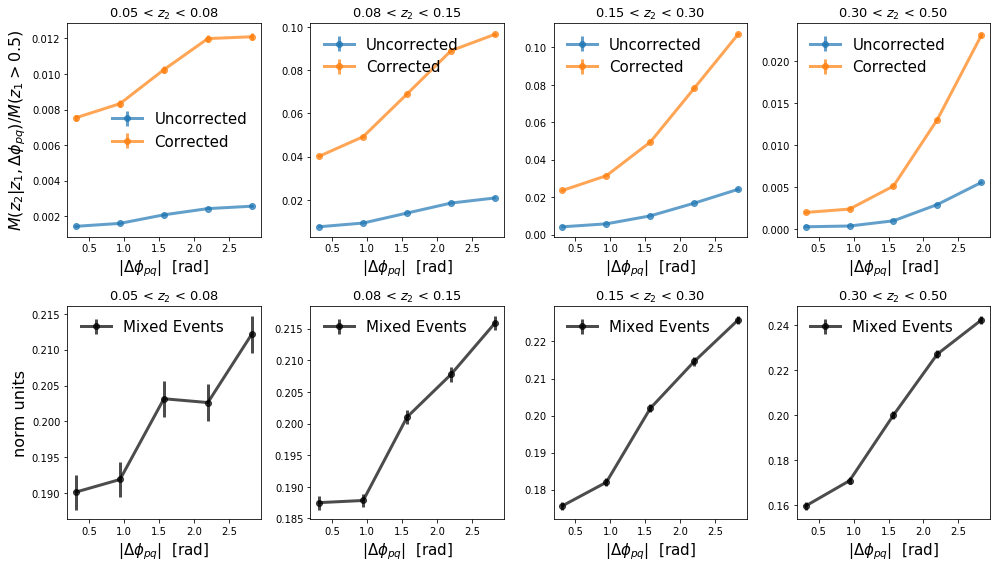

In [51]:
fig, axs = plt.subplots(2, 4, figsize=(14,8))
Edges = [0.4, 0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    print df_trigger['Pb_trigger'].query(query_trigger).shape[0]
    corr = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi.y, yerr=corr_D.sameh_dphi.yerr, linewidth=3.0,alpha=0.7,fmt='-o', label='Uncorrected')
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi, yerr=corr_D.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Corrected')

    axs[0,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=16)
    axs[0,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

    axs[1,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[1,j].errorbar(corr_D.bincenters_dphi, corr_D.mixh_dphi.y, yerr=corr_D.mixh_dphi.yerr, linewidth=3.0,alpha=0.7,fmt='-ko', label='Mixed Events')
    axs[1,0].yaxis.set_label_text('norm units',fontsize=16)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
    axs[1,j].legend(loc='best',frameon=False)

        
plt.tight_layout()
plt.savefig('EventMixing_AzimuthalCorrelations.png')

## Event mixing corrections for lab frame

z> 0.50 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08
277634
z> 0.50 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15
277634
z> 0.50 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30
277634
z> 0.50 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50
277634


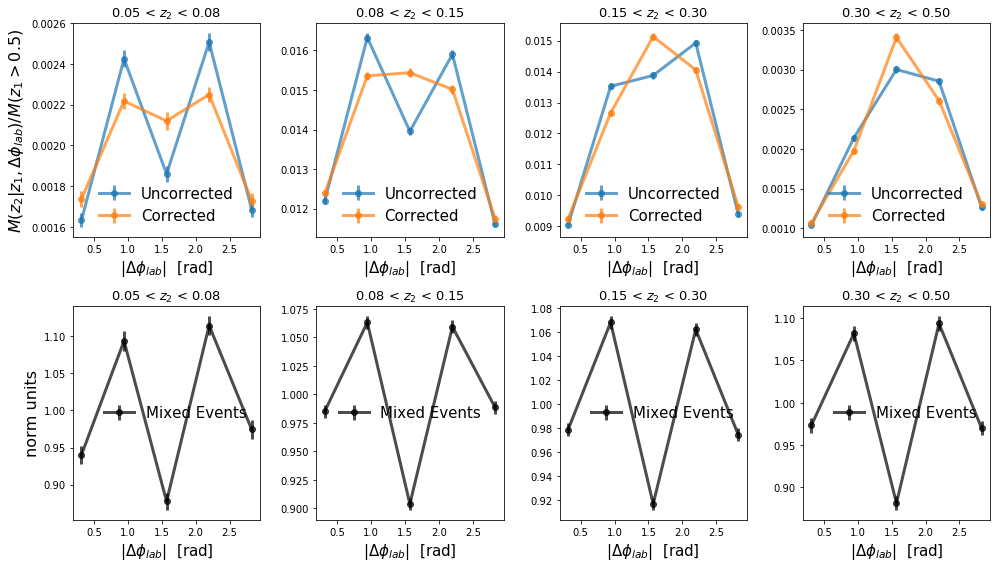

In [52]:
fig, axs = plt.subplots(2, 4,figsize=(14,8))
Edges = [0.4, 0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    print df_trigger['Pb_trigger'].query(query_trigger).shape[0]
    corr = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi_lab.y, yerr=corr_D.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o', label='Uncorrected')
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi_lab, yerr=corr_D.corr_dphi_lab_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Corrected')

    axs[0,j].xaxis.set_label_text("|$\Delta\phi_{lab}$|  [rad]", fontsize=15)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{lab})/M(z_{1}>0.5)$',fontsize=16)
    axs[0,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

    axs[1,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[1,j].errorbar(corr_D.bincenters_dphi, corr_D.mixh_dphi_lab.y, yerr=corr_D.mixh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-ko', label='Mixed Events')
    axs[1,0].yaxis.set_label_text('norm units',fontsize=16)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{lab}$|  [rad]", fontsize=15)
    axs[1,j].legend(loc='best',frameon=False)

        
plt.tight_layout()
plt.savefig('EventMixing_AzimuthalCorrelations_LabFrame.png')

# Azimuthal correlations

z> 0.50 and z<= 1.00  and z_asso>0.10 and z_asso<=0.15 
z> 0.50 and z<= 1.00  and z_asso>0.15 and z_asso<=0.25 
z> 0.50 and z<= 1.00  and z_asso>0.25 and z_asso<=0.50 
z> 0.50 and z<= 1.00 and z_asso>0.10 and z_asso<=0.15
z> 0.50 and z<= 1.00 and z_asso>0.15 and z_asso<=0.25
z> 0.50 and z<= 1.00 and z_asso>0.25 and z_asso<=0.50


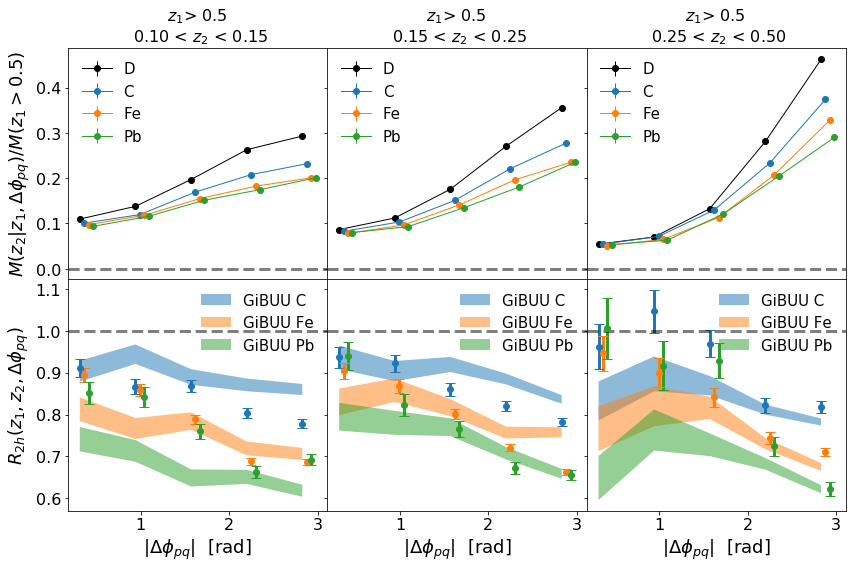

In [56]:
fig, axs = plt.subplots(2, 3,sharex=True,sharey='row', figsize=(12,8), gridspec_kw={'wspace':0, 'hspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
#asso_Edges = [0.06,0.1, 0.15,0.25,0.5]
asso_Edges = [0.1,0.15,0.25,0.5]#,0.3,0.5]

#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    ##Combined deuterium for plotting purposes
    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))
    
    #plots:
    #correlations
    

    axs[0,j].errorbar(np.subtract(corr_D.bincenters_dphi,0.0), corr_D.corr_dphi, yerr=corr_D.corr_dphi_err, linewidth=1.0,fmt='-ko', label='D')
    axs[0,j].errorbar(np.subtract(corr_C.bincenters_dphi,-0.05), corr_C.corr_dphi, yerr=corr_C.corr_dphi_err, linewidth=1.0,fmt='-o', label='C')
    axs[0,j].errorbar(np.subtract(corr_Fe.bincenters_dphi,-0.10), corr_Fe.corr_dphi, yerr=corr_Fe.corr_dphi_err, linewidth=1.0,fmt='-o', label='Fe')
    axs[0,j].errorbar(np.subtract(corr_Pb.bincenters_dphi,-0.15),corr_Pb.corr_dphi, yerr=corr_Pb.corr_dphi_err, linewidth=1.0,fmt='-o', label='Pb')

    

    axs[1,j].errorbar(np.subtract(corr_D.bincenters_dphi,0.0), comp_C.ratio, yerr=comp_C.ratio_err,capsize=5, lw=3.0,fmt='o')
    axs[1,j].errorbar(np.subtract(corr_D.bincenters_dphi,-0.05), comp_Fe.ratio, yerr=comp_Fe.ratio_err, capsize=5,lw=3.0,fmt='o')
    axs[1,j].errorbar(np.subtract(corr_D.bincenters_dphi,-0.10), comp_Pb.ratio, yerr=comp_Pb.ratio_err, capsize=5,lw=3.0,fmt='o')

    #axs[j].errorbar(corr_Fe.bincenters_dphi, corr_Fe.corr_dphi, yerr=corr_Fe.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Fe')
    #axs[j].errorbar(corr_Pb.bincenters_dphi, corr_Pb.corr_dphi, yerr=corr_Pb.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Pb')
    
    axs[0,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=18)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=18)

    axs[1,0].yaxis.set_label_text(r'$R_{2h}(z_{1},z_{2}, \Delta\phi_{pq}) $',fontsize=18)
    axs[1,j].axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

    axs[0,j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=16)

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f'%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    
    corr_D = correlation(df_trigger['GiBUU_D_trigger'].query(query_trigger).shape[0], df['GiBUU_D'].query(query_total), df['GiBUU_D'].query(query_total))
    norma = np.sum(corr_D.sameh_dphi_lab.y)
    corr_D.normalize(norma)
    #axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi_lab.y, yerr=corr_D.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o',label='D')
    
    for target in ['C','Fe','Pb']:
        corr = correlation(df_trigger['GiBUU_%s_trigger'%target].query(query_trigger).shape[0], df['GiBUU_%s'%target].query(query_total), df['GiBUU_%s'%target].query(query_total))
        corr.normalize(norma)
        #axs[0,j].errorbar(corr.bincenters_dphi, corr.sameh_dphi_lab.y, yerr=corr.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o',label=target)
        
        ratio = np.true_divide(corr.sameh_dphi_lab.y,corr_D.sameh_dphi_lab.y)
        ratio_err = np.sqrt(np.power(np.divide(corr.sameh_dphi_lab.yerr,corr.sameh_dphi_lab.y),2.0)
                            +np.power(np.divide(corr.sameh_dphi_lab.yerr,corr.sameh_dphi_lab.y),2.0))*ratio 
        
        #comp = comparison(corr,corr_D)
        axs[1,j].fill_between(corr.bincenters_dphi, ratio-ratio_err,ratio+ratio_err,alpha=0.5,label='GiBUU %s'%target)
        #comp = comparison(corr,corr_D)
        #axs[1,j].errorbar(corr.bincenters_dphi, y=ratio, linewidth=3.0,alpha=0.7,fmt='--',label='GiBUU %s'%target)
        axs[1,j].legend(loc='upper right',frameon=False)

    axs[1,j].tick_params(axis="x", labelsize=16)
    axs[1,j].tick_params(axis="y", labelsize=16)
    axs[0,j].tick_params(axis="x", labelsize=16)
    axs[0,j].tick_params(axis="y", labelsize=16)             
plt.tight_layout()
plt.savefig('AzimuthalCorrelations_differentialz2.png')
plt.savefig('AzimuthalCorrelations_differentialz2.pdf')

## Azimuthal correlations for GiBUU

z> 0.50 and z<= 1.00 and z_asso>0.08 and z_asso<=0.50
0
-0.0
1
-0.04
2
-0.08


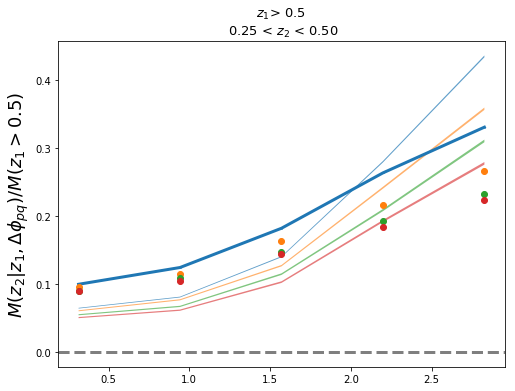

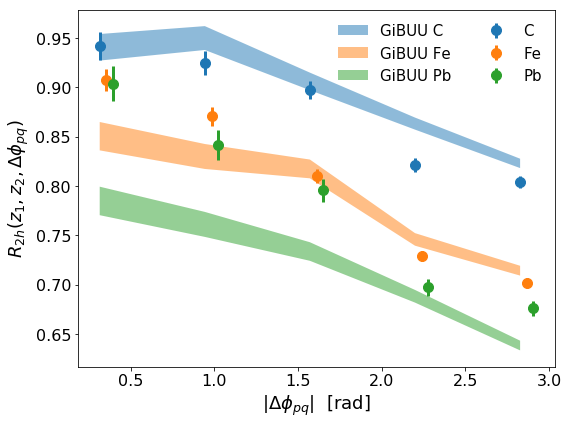

In [55]:
#fig, axs = plt.subplots(1, 2,sharex=True,figsize=(12,6))
fig1 = plt.figure(1,figsize=(8,6))
axs = []
axs.append(plt.gca())
fig2= plt.figure(2,figsize=(8,6))
axs.append(plt.gca())

asso_Edges = [0.08, 0.5]
query_trigger = 'z> %2.2f and z<= %2.2f'%(0.5,1.0)
query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_Edges[0],asso_Edges[1])
query_total = query_trigger + ' and '+ query_asso
print query_total
    
    
corr_D_GiBUU = correlation(df_trigger['GiBUU_D_trigger'].query(query_trigger).shape[0], df['GiBUU_D'].query(query_total), df['GiBUU_D'].query(query_total))
norma_GiBUU = np.sum(corr_D_GiBUU.sameh_dphi_lab.y)
corr_D_GiBUU.normalize(norma_GiBUU)
y = corr_D_GiBUU.sameh_dphi_lab.y
yerr = corr_D_GiBUU.sameh_dphi_lab.yerr
x = corr_D_GiBUU.bincenters_dphi
axs[0].fill_between(x, y-yerr,y+yerr, linewidth=3.0,alpha=0.7)
    


##Combined deuterium for plotting purposes
corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
corr_D.normalize(np.sum(corr_D.corr_dphi))
axs[0].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi, yerr=corr_D.corr_dphi_err, linewidth=3.0)
    
for i,target in enumerate(['C','Fe','Pb']):
    print i
    offset = int(i)*-0.04
    print offset
    ##Data
    corr = correlation(df_trigger['%s_trigger'%target].query(query_trigger).shape[0], df['%s'%target].query(query_total), df['%s_mix'%target].query(query_total))
    corr_ref = correlation(df_trigger['D_%s_trigger'%target].query(query_trigger).shape[0], df['D_%s'%target].query(query_total), df['D_%s_mix'%target].query(query_total))
    norma = np.sum(corr_ref.corr_dphi)
    corr.normalize(norma)
    corr_ref.normalize(norma)
    
    axs[0].errorbar(corr.bincenters_dphi, corr.corr_dphi, yerr=corr.corr_dphi_err, lw=3.0,fmt='o')
    
    #comparison between D and Nuclei
    comp = comparison(corr,corr_ref)
    axs[1].errorbar(np.subtract(corr_ref.bincenters_dphi,offset), comp.ratio, yerr=comp.ratio_err, ms=10,lw=3.0,fmt='o',label='%s'%target)

    
    ###GIBUU    
    corr = correlation(df_trigger['GiBUU_%s_trigger'%target].query(query_trigger).shape[0], df['GiBUU_%s'%target].query(query_total), df['GiBUU_%s'%target].query(query_total))
    corr.normalize(norma_GiBUU)
    y = corr.sameh_dphi_lab.y
    yerr = corr.sameh_dphi_lab.yerr
    x  = corr.bincenters_dphi
    axs[0].fill_between(x, y-yerr,y+yerr, linewidth=3.0,alpha=0.6)
    ratio = np.true_divide(corr.sameh_dphi_lab.y,corr_D_GiBUU.sameh_dphi_lab.y)
    ratio_err = np.sqrt(np.power(np.divide(corr.sameh_dphi_lab.yerr,corr.sameh_dphi_lab.y),2.0)
                        +np.power(np.divide(corr_D_GiBUU.sameh_dphi_lab.yerr,corr_D_GiBUU.sameh_dphi_lab.y),2.0))*ratio 
        
    axs[1].fill_between(corr.bincenters_dphi, ratio-ratio_err,ratio+ratio_err,alpha=0.5,label='GiBUU %s'%target)
      
        #labelling
axs[0].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
axs[1].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=18)
axs[0].legend(loc='best',frameon=False)
axs[0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=18)
axs[1].yaxis.set_label_text(r'$R_{2h}(z_{1},z_{2}, \Delta\phi_{pq}) $',fontsize=18)
#axs[1].axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
axs[0].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
axs[1].legend(loc='best',frameon=False,ncol=2)
axs[1].tick_params(axis="x", labelsize=16)
axs[1].tick_params(axis="y", labelsize=16)

plt.tight_layout()

fig1.savefig('AzimuthalCorrelations_GiBUU.png')  
plt.tight_layout()

fig2.savefig('R2h_AzimuthalCorrelations_GiBUU.png')  
fig2.savefig('R2h_AzimuthalCorrelations_GiBUU.pdf')  
plt.show()

## Azimuthal correlations, various z2 bins

z> 0.50 and z<= 1.00 and z_asso>0.10 and z_asso<=0.50


KeyError: 'GiBUU_Pb_trigger'

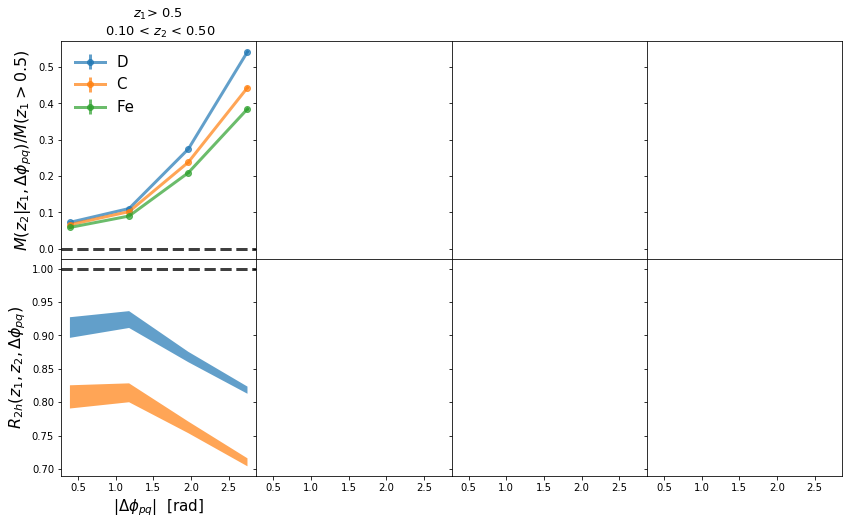

In [19]:
fig, axs = plt.subplots(2, 4,sharex=True,sharey='row', figsize=(14,8), gridspec_kw={'wspace':0, 'hspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
#asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
#asso_Edges = [0.08,0.1, 0.15,0.3,0.5]
asso_Edges = [0.1, 0.5]

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f'%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    
    corr_D = correlation(df_trigger['GiBUU_D_trigger'].query(query_trigger).shape[0], df['GiBUU_D'].query(query_total), df['GiBUU_D'].query(query_total))
    norma = np.sum(corr_D.sameh_dphi_lab.y)
    corr_D.normalize(norma)
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi_lab.y, yerr=corr_D.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o',label='D')
    
    for target in ['C','Fe','Pb']:
        corr = correlation(df_trigger['GiBUU_%s_trigger'%target].query(query_trigger).shape[0], df['GiBUU_%s'%target].query(query_total), df['GiBUU_%s'%target].query(query_total))
        corr.normalize(norma)
        axs[0,j].errorbar(corr.bincenters_dphi, corr.sameh_dphi_lab.y, yerr=corr.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o',label=target)
        
        ratio = np.true_divide(corr.sameh_dphi_lab.y,corr_D.sameh_dphi_lab.y)
        ratio_err = np.sqrt(np.power(np.divide(corr.sameh_dphi_lab.yerr,corr.sameh_dphi_lab.y),2.0)
                            +np.power(np.divide(corr.sameh_dphi_lab.yerr,corr.sameh_dphi_lab.y),2.0))*ratio 
        
        #comp = comparison(corr,corr_D)
        axs[1,j].fill_between(corr.bincenters_dphi, ratio-ratio_err,ratio+ratio_err,alpha=0.7)
        
        #labelling
        axs[0,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
        axs[1,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
        axs[0,j].legend(loc='best',frameon=False)
        axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=16)
        axs[1,0].yaxis.set_label_text(r'$R_{2h}(z_{1},z_{2}, \Delta\phi_{pq}) $',fontsize=16)
        axs[1,j].axhline(y=1.0,color='black',linestyle='--',alpha=0.5)
        axs[0,j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
#plt.tight_layout()
plt.savefig('AzimuthalCorrelations_GiBUU.png')    

## Missing Mass vs z2 (for fixed z1)

z> 0.50 and z<= 1.00  and z_asso>0.05 and z_asso<=0.10 
z> 0.50 and z<= 1.00  and z_asso>0.10 and z_asso<=0.20 
z> 0.50 and z<= 1.00  and z_asso>0.20 and z_asso<=0.35 
z> 0.50 and z<= 1.00  and z_asso>0.35 and z_asso<=0.50 


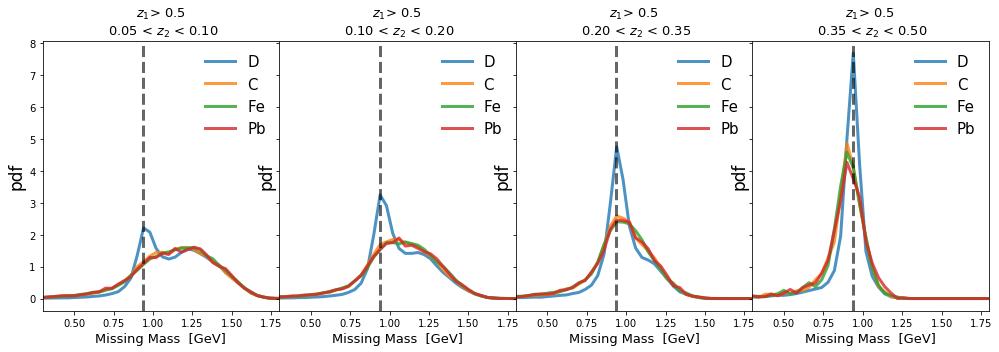

In [57]:
fig, axs = plt.subplots(1, 4,sharex=True,sharey=True, figsize=(14,5), gridspec_kw={'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.2,0.35,0.5]
#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))
    
    
    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    axs[j].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
    axs[j].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
    axs[j].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
    axs[j].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
    plt.xlim([0.3,1.8])

    axs[j].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
    #axs[2].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].legend(loc='best',frameon=False)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[j].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].yaxis.set_label_text("pdf")
        
plt.tight_layout()
plt.savefig('MissingMass.png')

## Dipion Mass vs z2 for fixed z1

z> 0.40 and z<= 1.00  and z_asso>0.05 and z_asso<=0.10
z> 0.40 and z<= 1.00  and z_asso>0.10 and z_asso<=0.15
z> 0.40 and z<= 1.00  and z_asso>0.15 and z_asso<=0.20
z> 0.40 and z<= 1.00  and z_asso>0.20 and z_asso<=0.25


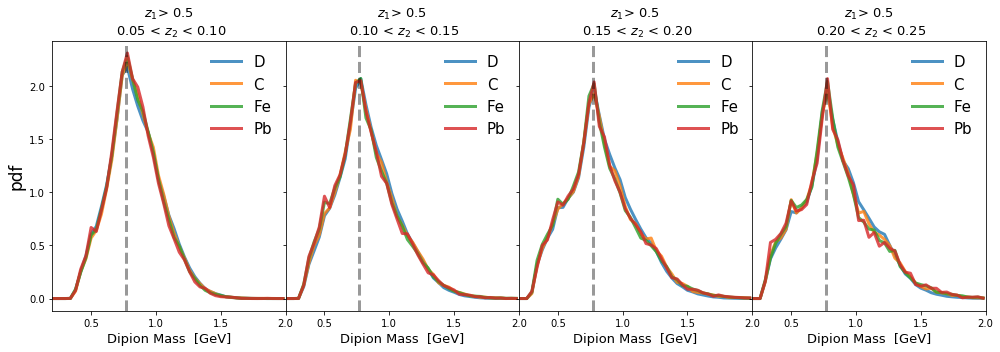

In [58]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.15,0.20,0.25]
#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.4,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    
    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))

    axs[j].plot(corr_C.hmass_x,corr_D.hmass,label='D',alpha=0.8)
    #axs[j].plot(corr_C.hmass_x,corr_D_C.hmass_mix,label='D (mix)')

    axs[j].plot(corr_C.hmass_x,corr_C.hmass,label='C',alpha=0.8)
    axs[j].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe',alpha=0.8)
    axs[j].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb',alpha=0.8)
    #axs[j].fill(corr_D.hmass_x,corr_D.hmass_mix,label='(mixed)',alpha=0.4)
    #axs[j].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='(mixed Pb)',alpha=0.4)


    axs[j].axvline(x=0.770,linestyle='--',color='black',alpha=0.4)
    #axs[2].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].legend(loc='best',frameon=False)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[j].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[0].yaxis.set_label_text("pdf")
    plt.xlim([0.2,2.0])

        
plt.tight_layout()
plt.savefig('Dipion_InvariantMass_anti.png')

## 2D Missing Mass (z1,z2)

z> 0.50 and z<= 0.60  and z_asso>0.05 and z_asso<=0.08 
z> 0.60 and z<= 0.70  and z_asso>0.05 and z_asso<=0.08 
z> 0.70 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08 
z> 0.50 and z<= 0.60  and z_asso>0.08 and z_asso<=0.15 
z> 0.60 and z<= 0.70  and z_asso>0.08 and z_asso<=0.15 
z> 0.70 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15 
z> 0.50 and z<= 0.60  and z_asso>0.15 and z_asso<=0.30 
z> 0.60 and z<= 0.70  and z_asso>0.15 and z_asso<=0.30 
z> 0.70 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30 
z> 0.50 and z<= 0.60  and z_asso>0.30 and z_asso<=0.50 
z> 0.60 and z<= 0.70  and z_asso>0.30 and z_asso<=0.50 
z> 0.70 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50 


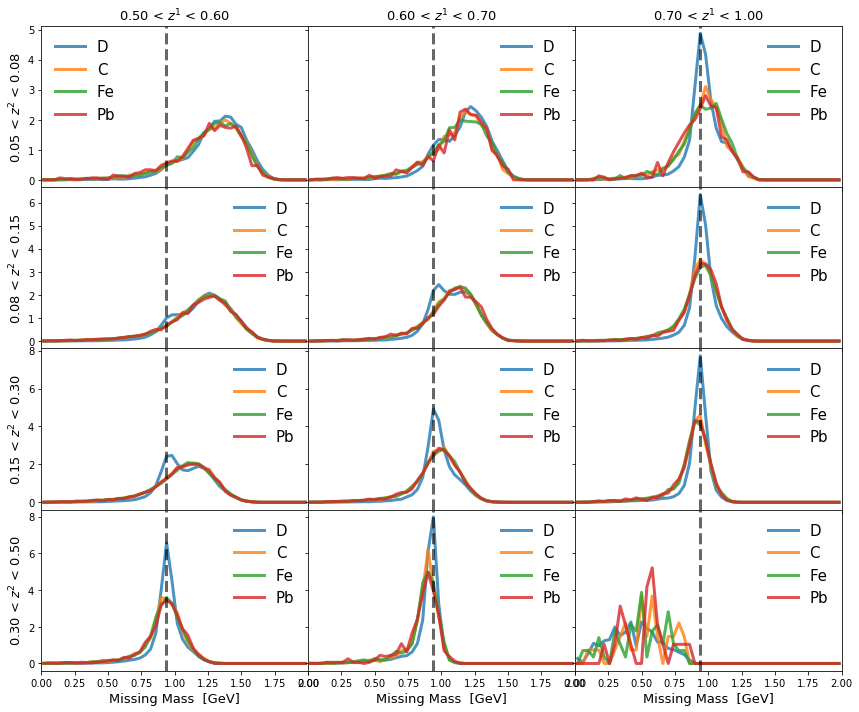

In [59]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.30,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
               
        axs[j,i].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
        axs[j,i].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
        axs[j,i].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
        axs[j,i].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
        #axs[j,i].fill(corr_Pb.hxmass_x,corr_Pb.hxmass_mix,label='(mixed)',alpha=0.4)

        plt.xlim([0.0,2.0])

        axs[j,i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
        axs[3,i].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text(r'$\frac{1}{N_{\mathrm{trigger}}} \mathrm{d}N_{\mathrm{pairs}}$',fontsize=18)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('MissingMass_2D.png')

## 2D Missing Mass (z1,z1+z2)

z> 0.50 and z<= 0.60  and z+z_asso>0.55 and z+z_asso<=0.65 
z> 0.60 and z<= 0.70  and z+z_asso>0.55 and z+z_asso<=0.65 


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/pytho

z> 0.70 and z<= 1.00  and z+z_asso>0.55 and z+z_asso<=0.65 
z> 0.50 and z<= 0.60  and z+z_asso>0.65 and z+z_asso<=0.70 
z> 0.60 and z<= 0.70  and z+z_asso>0.65 and z+z_asso<=0.70 
z> 0.70 and z<= 1.00  and z+z_asso>0.65 and z+z_asso<=0.70 
z> 0.50 and z<= 0.60  and z+z_asso>0.70 and z+z_asso<=0.80 
z> 0.60 and z<= 0.70  and z+z_asso>0.70 and z+z_asso<=0.80 
z> 0.70 and z<= 1.00  and z+z_asso>0.70 and z+z_asso<=0.80 
z> 0.50 and z<= 0.60  and z+z_asso>0.80 and z+z_asso<=1.00 
z> 0.60 and z<= 0.70  and z+z_asso>0.80 and z+z_asso<=1.00 
z> 0.70 and z<= 1.00  and z+z_asso>0.80 and z+z_asso<=1.00 


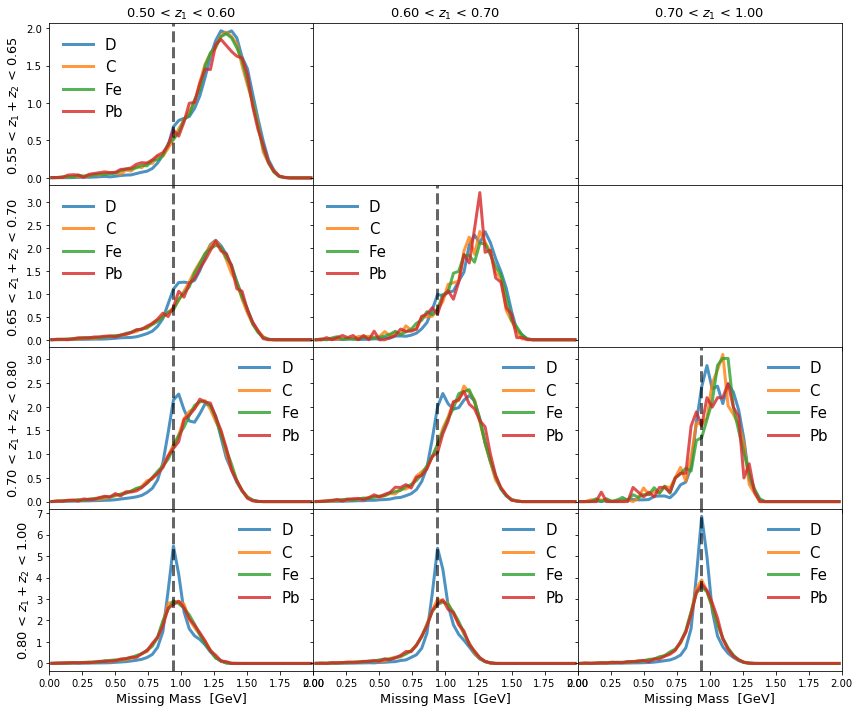

In [60]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.55, 0.65,0.70,0.8,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
            axs[j,i].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
            axs[j,i].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
            axs[j,i].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
            #axs[j,i].fill(corr_D.hxmass_x,corr_D.hxmass_mix,label='(mixed)',alpha=0.4)

            plt.xlim([0.0,2.0])

            axs[j,i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
            axs[3,i].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('MissingMass_2D_z1z2.png')

## 2D Invariant Mass (z1, z2)

z> 0.50 and z<= 0.60  and z_asso>0.05 and z_asso<=0.08
z> 0.60 and z<= 0.70  and z_asso>0.05 and z_asso<=0.08
z> 0.70 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08
z> 0.50 and z<= 0.60  and z_asso>0.08 and z_asso<=0.15
z> 0.60 and z<= 0.70  and z_asso>0.08 and z_asso<=0.15
z> 0.70 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15
z> 0.50 and z<= 0.60  and z_asso>0.15 and z_asso<=0.30
z> 0.60 and z<= 0.70  and z_asso>0.15 and z_asso<=0.30
z> 0.70 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30
z> 0.50 and z<= 0.60  and z_asso>0.30 and z_asso<=0.50
z> 0.60 and z<= 0.70  and z_asso>0.30 and z_asso<=0.50
z> 0.70 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50


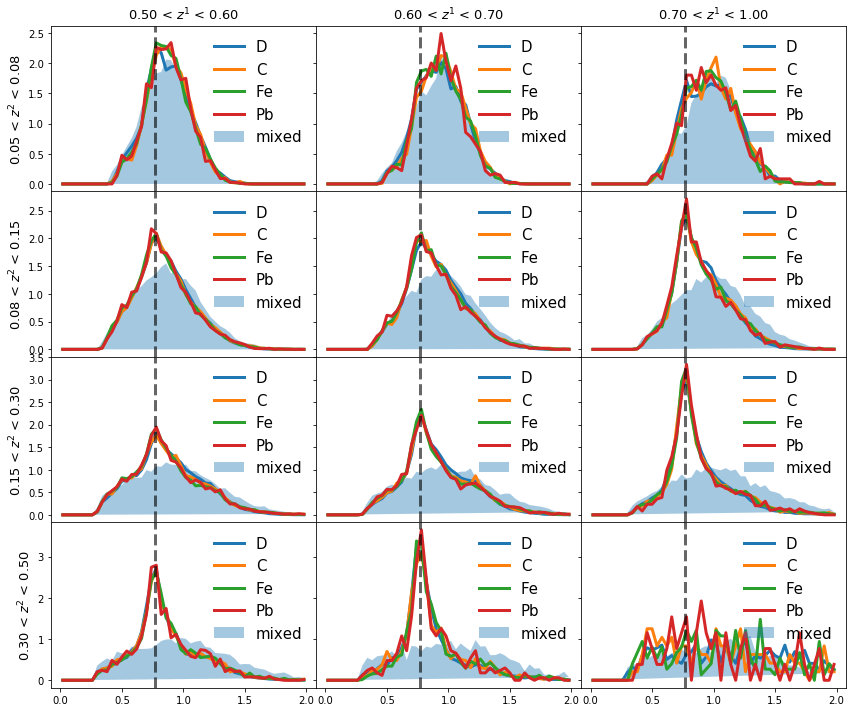

In [61]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.30,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
               
        axs[j,i].plot(corr_D.hmass_x,corr_D.hmass,label='D')
        axs[j,i].plot(corr_C.hmass_x,corr_C.hmass,label='C')
        axs[j,i].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe')
        axs[j,i].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb')
        axs[j,i].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='mixed',alpha=0.4)
        #axs[j,i].fill(corr_Fe.hmass_x,corr_Fe.hmass_mix,label='Fe (mix)',alpha=0.4)
        
        axs[j,i].axvline(x=0.770,color='black',alpha=0.6,linestyle='--')
        axs[2,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text(r'$\frac{1}{N_{\mathrm{trigger}}} \mathrm{d}N_{\mathrm{pairs}}$',fontsize=18)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('Mass_2D.png')

## 2D Invariant Mass (z1, z1+z2)

z> 0.40 and z<= 0.50  and z+z_asso>0.50 and z+z_asso<=0.55


KeyError: 'C_trigger'

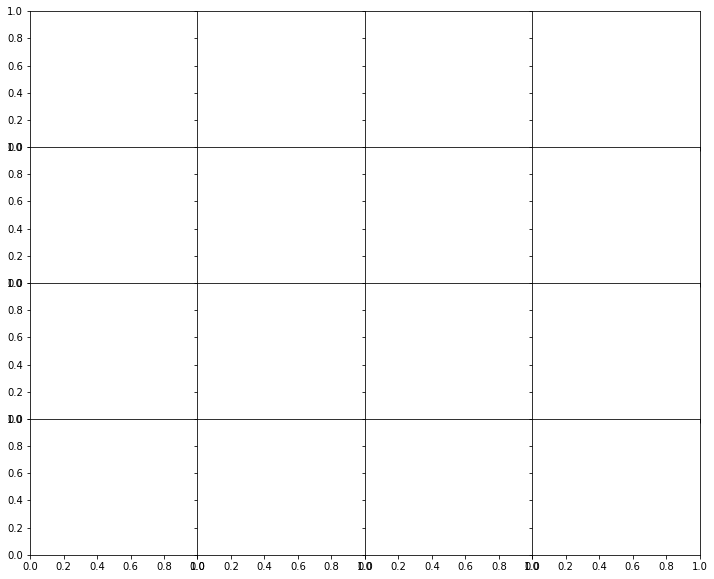

In [62]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.5,0.55, 0.65,0.70,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.hmass_x,corr_D.hmass,label='D')
            #axs[j,i].fill(corr_C.hmass_x,corr_C.hmass_mix,label='C (mix)',alpha=0.4)
            #axs[j,i].fill(corr_Fe.hmass_x,corr_Fe.hmass_mix,label='Fe (mix)',alpha=0.4)

            axs[j,i].plot(corr_C.hmass_x,corr_C.hmass,label='C')
            axs[j,i].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe')
            axs[j,i].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb')
            axs[j,i].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='mixed',alpha=0.4)

            axs[j,i].axvline(x=0.770,color='black',alpha=0.6,linestyle='--')
            axs[3,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('Mass_2D_z1z2.png')

## 2D t distribution vs z1+z2 and z1

z> 0.50 and z<= 0.60  and z+z_asso>0.50 and z+z_asso<=0.55


KeyError: 'C_trigger'

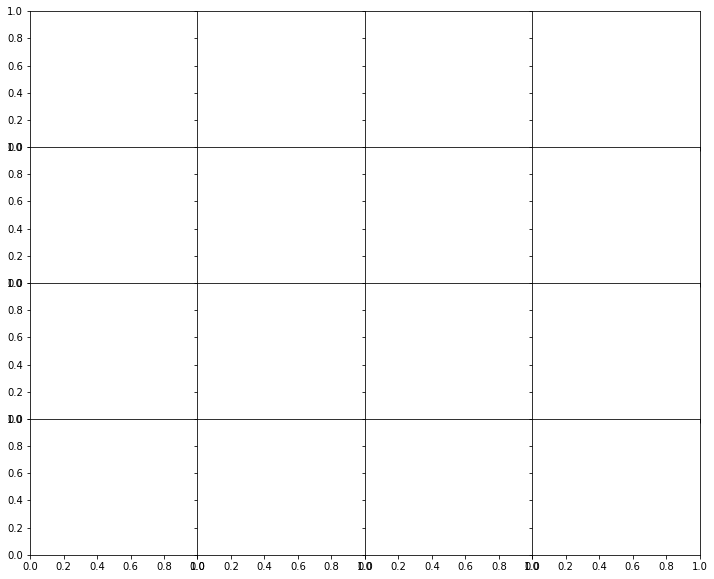

In [63]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.5,0.55, 0.65,0.70,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.dipion_pt_x,corr_D.dipion_pt,label='D')
            axs[j,i].plot(corr_C.dipion_pt_x,corr_C.dipion_pt,label='C')
            axs[j,i].plot(corr_Fe.dipion_pt_x,corr_Fe.dipion_pt,label='Fe')
            axs[j,i].plot(corr_Pb.dipion_pt_x,corr_Pb.dipion_pt,label='Pb')

#            axs[j,i].axvline(x=0.4,linestyle='--',color='black',alpha=0.6)
            axs[3,i].xaxis.set_label_text("dipion pT  [GeV]$", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('t_2D_z1z2.png')

## t distribution

z> 0.40 and z<= 0.50  and z_asso>0.05 and z_asso<=0.10 


KeyError: 'C_trigger'

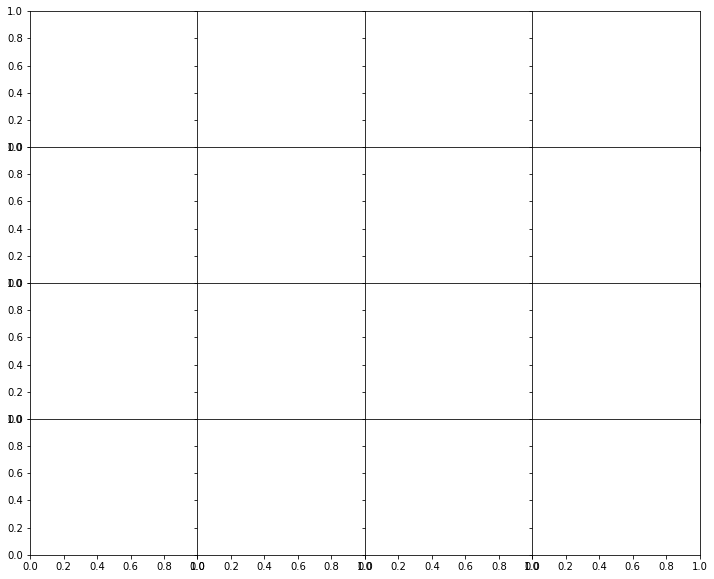

In [64]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.15,0.25,0.4]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        axs[j,i].plot(corr_D.dipion_pt_x,corr_D.t,label='D')
        axs[j,i].plot(corr_C.dipion_pt_x,corr_C.t,label='C')
        axs[j,i].plot(corr_Fe.dipion_pt_x,corr_Fe.t,label='Fe')
        axs[j,i].plot(corr_Pb.dipion_pt_x,corr_Pb.t,label='Pb')

        plt.xlim([0.0,3.0])

        axs[j,i].axvline(x=0.4,linestyle='--',color='black',alpha=0.6)
        axs[3,i].xaxis.set_label_text("dipion pt [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('dipion.png')

## Checking R2h as a function of z_tot instead of z2

In [65]:
df['Pb'].keys()


Index([u'Nu', u'Q2', u'W', u'Xb', u'dipion_pt', u'dphi', u'dphi_lab', u'dy',
       u'mass', u'missing_mass', u'phi_lab', u'phi_lab_asso', u'phi_pq',
       u'phi_pq_asso', u'pid', u'pid_asso', u't', u'theta_lab',
       u'theta_lab_asso', u'theta_pq', u'theta_pq_asso', u'u', u'xf',
       u'xf_asso', u'y', u'y_asso', u'ycm', u'z', u'z_asso', u'inelasticity',
       u'E', u'P', u'z_tot', u'E_asso', u'P_asso'],
      dtype='object')

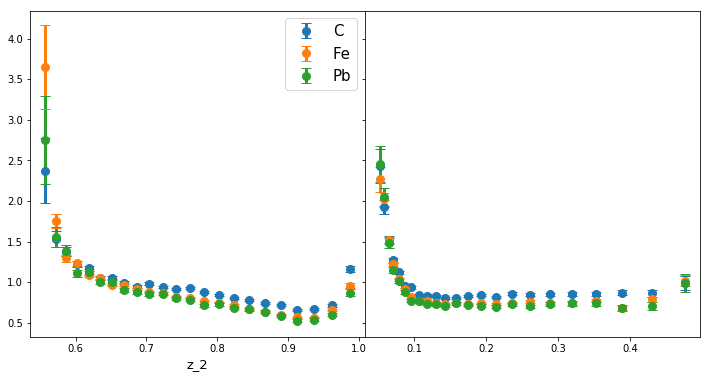

In [66]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.55,maxz=1.0,variable='z_tot')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    
axs[0].legend()
axs[0].xaxis.set_label_text("z_2", fontsize=13)


## Compare results with and without z_tot<0.8 cut

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


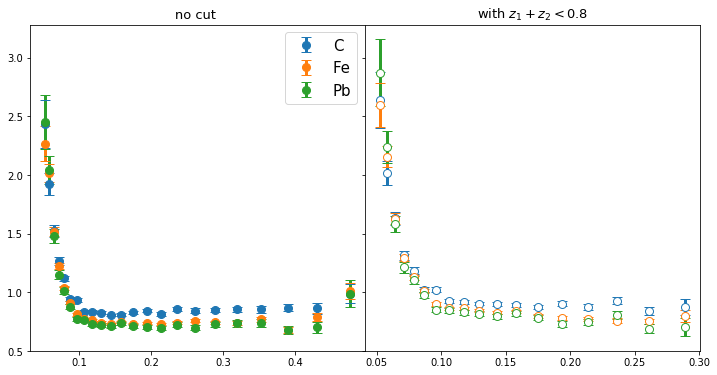

In [67]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


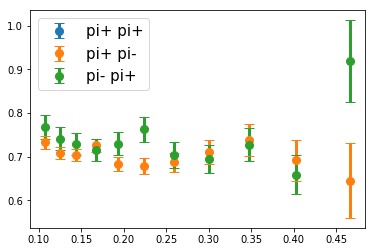

In [68]:
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid<0', pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)

plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


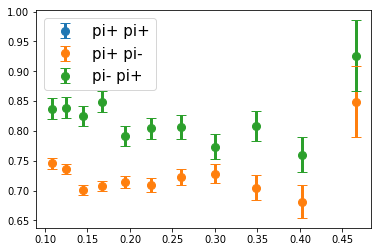

In [69]:
r, err, x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid<0', pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()
plt.show()

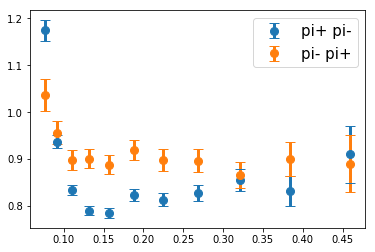

In [70]:
#r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
#plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],trig_cut='z>0.5 and pid>0', minz=0.07,pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],trig_cut='z>0.5 and pid<0', minz=0.07,pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


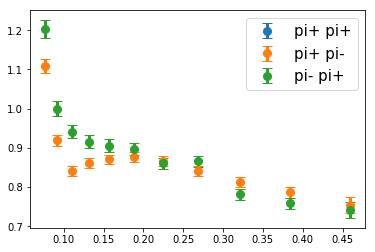

In [71]:
r, err, x = getRatio(df['GiBUU_C'],df['GiBUU_D'],df_trigger['GiBUU_C_trigger'],df_trigger['GiBUU_D_trigger'],trig_cut='z>0.5 and pid>0', minz=0.07,pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['GiBUU_C'],df['GiBUU_D'],df_trigger['GiBUU_C_trigger'],df_trigger['GiBUU_D_trigger'],trig_cut='z>0.5 and pid>0', minz=0.07,pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['GiBUU_C'],df['GiBUU_D'],df_trigger['GiBUU_C_trigger'],df_trigger['GiBUU_D_trigger'],trig_cut='z>0.5 and pid<0', minz=0.07,pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()
plt.show()

## Same sign results:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


<Container object of 3 artists>

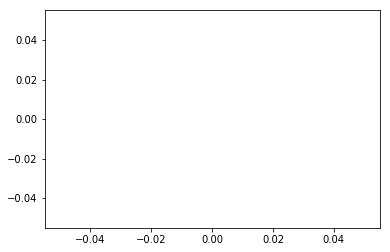

In [72]:
r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='C, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='Fe, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='Pb, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

In [ ]:
## Varying Nu

In [73]:
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and Nu>3.2')
plt.errorbar(x,r,yerr=err,label='Nu>3.2',fmt='o',ms=8,lw=3,capsize=5)
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and Nu<3.2')
plt.errorbar(x,r,yerr=err,label='Nu<3.2',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()

TypeError: getRatio() got an unexpected keyword argument 'query'

In [ ]:
r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],query='and pid*pid_asso<0')
plt.errorbar(x,r,yerr=err,label='C, Lead, same sign',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and pid*pid_asso<0')
plt.errorbar(x,r,yerr=err,label='Pb, Lead, same sign',fmt='o',ms=8,lw=3,capsize=5)

plt.show()
plt.legend()

## z2 distribution breakdown for pi+ and pi- for all nuclei

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('z>0.5 and pid_asso>0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('z>0.5 and pid_asso<0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid>0')['z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid<0')['z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

In [ ]:
plt.hist(df['Pb'].query('z>0.5 and pid_asso>0')['P_asso'], bins=30,range =(0,1.5),label='pi+',alpha=0.5)
plt.hist(df['Pb'].query('z>0.5 and pid_asso<0')['P_asso'], bins=30,range =(0,1.5),label='pi-',alpha=0.5)

plt.title('Conditional distribution for $z_{1}>0.5$',fontsize=16)
plt.ylabel('pairs',fontsize=16)
plt.xlabel('$P_{2}$',fontsize=16)
        
plt.tight_layout()
plt.savefig('ConditionalDistributionMomentum_Deuterium.png')